### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)


/Users/toby/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12433
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|     4|[80 4D 80 C9 00 0...|1907.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    29|[00 7E A0 53 00 C...|1911.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    18|[40 CC 40 4C 80 C...|1912.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    36|[40 56 A0 56 58 5...|1915.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    40|[20 50 30 54 30 5...|1916.0|SSSBBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [2]:
pwd

u'/Users/toby/PycharmProjects/clm024/DSE230/Classes/2.PCA'

In [6]:
!ls ../../Data/Weather

PRCP_residuals_PCA.pickle   decon_BBBSBBBB_SNWD.parquet
STAT_BBBSBBBB.pickle        decon_BBBSBBBB_TOBS.parquet
STAT_SSSBBSSB.pickle        decon_SSSBBSSB_PRCP.parquet
US_Weather_BBBSBBBB.csv     decon_SSSBBSSB_SNWD.parquet
US_Weather_BBBSBBBB.csv.gz  ghcnd-readme.txt
US_Weather_BBBSBBBB.parquet ghcnd-stations.txt
US_Weather_SSSBBSSB.csv     ghcnd-stations_buffered.txt
US_Weather_SSSBBSSB.csv.gz  ghcnd-version.txt
US_Weather_SSSBBSSB.parquet stations.pkl
data-source.txt             stations.pkl.gz
decon_BBBSBBBB.parquet


In [7]:
!ls $filename

_SUCCESS
part-00000-b728bec1-3f5e-4fc7-a8af-787ba93bcd64.snappy.parquet
part-00001-b728bec1-3f5e-4fc7-a8af-787ba93bcd64.snappy.parquet
part-00002-b728bec1-3f5e-4fc7-a8af-787ba93bcd64.snappy.parquet


### Select data for a particular station and measurement type

In [8]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00421272')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00421272'
46 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|     4|[80 4D 80 C9 00 0...|1907.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    29|[00 7E A0 53 00 C...|1911.0|SSSBBSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(46, 365)

In [9]:
Query= """\
SELECT measurement FROM weather 
WHERE GROUP BY measurement
"""
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()

SELECT measurement FROM weather 
WHERE GROUP BY measurement

6 rows
+-----------+
|measurement|
+-----------+
|       TMIN|
|       TOBS|
|       TMAX|
|       SNOW|
|       SNWD|
|       PRCP|
+-----------+



In [20]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query= """\
SELECT year FROM weather 
WHERE measurement='SNWD'
and station='USC00421272' GROUP BY year
ORDER BY year ASC
"""
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()


SELECT year FROM weather 
WHERE measurement='SNWD'
and station='USC00421272' GROUP BY year
ORDER BY year ASC

33 rows
+------+
|  year|
+------+
|1928.0|
|1929.0|
|1930.0|
|1931.0|
|1932.0|
|1933.0|
|1934.0|
|1935.0|
|1936.0|
|1937.0|
|1938.0|
|1939.0|
|1940.0|
|1941.0|
|1942.0|
|1943.0|
|1944.0|
|1945.0|
|1946.0|
|1947.0|
+------+
only showing top 20 rows



In [10]:
Query= """\
SELECT station, count(year) FROM weather 
WHERE GROUP BY station
ORDER BY station
"""
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(99)

SELECT station, count(year) FROM weather 
WHERE GROUP BY station
ORDER BY station

99 rows
+-----------+-----------+
|    station|count(year)|
+-----------+-----------+
|US1UTGF0003|          3|
|US1UTIR0003|          3|
|US1UTSJ0001|          2|
|USC00260015|          1|
|USC00260099|        142|
|USC00260645|          1|
|USC00261358|        396|
|USC00261590|         54|
|USC00262557|        132|
|USC00262562|         89|
|USC00263671|        126|
|USC00264143|         74|
|USC00265880|        214|
|USC00265950|          1|
|USC00266252|        350|
|USC00268538|         28|
|USC00420086|        526|
|USC00420157|        154|
|USC00420400|          2|
|USC00420738|        475|
|USC00420757|        195|
|USC00420788|        492|
|USC00420849|        324|
|USC00420900|         82|
|USC00421006|         36|
|USC00421007|        112|
|USC00421008|        297|
|USC00421020|        194|
|USC00421162|         18|
|USC00421259|         66|
|USC00421260|        111|
|USC00421272|        245|

In [15]:
ba = df1.rdd.map(lambda row:row['vector']).collect()

In [17]:
len(ba)

46

In [23]:
T[0][:5]

array([ 2.19921875,  0.60009766,  7.80078125,  7.80078125,  6.1015625 ], dtype=float16)

### Script for plotting yearly plots

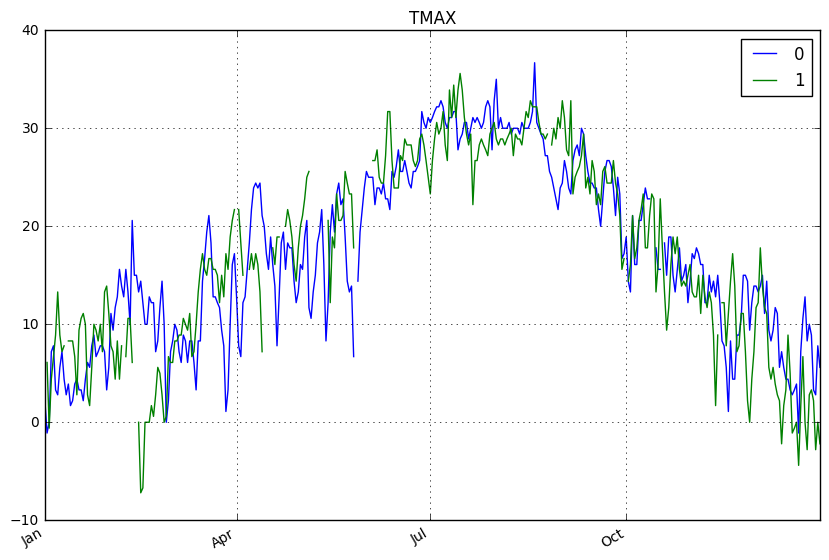

In [11]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMAX')

#YP.plot(T[:2,:].transpose(),fig,ax,title='TMAX')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [12]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)


In [15]:
STAT['TMAX']['NE'][0]

2346.0

/Users/toby/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


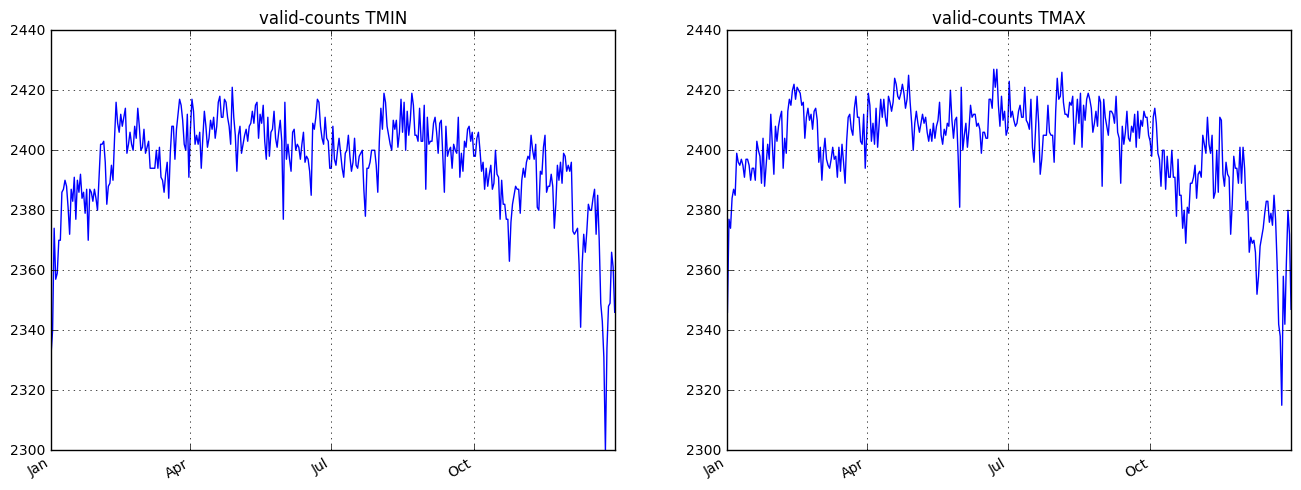

In [13]:
plot_pair(['TMIN','TMAX'],plot_valid)

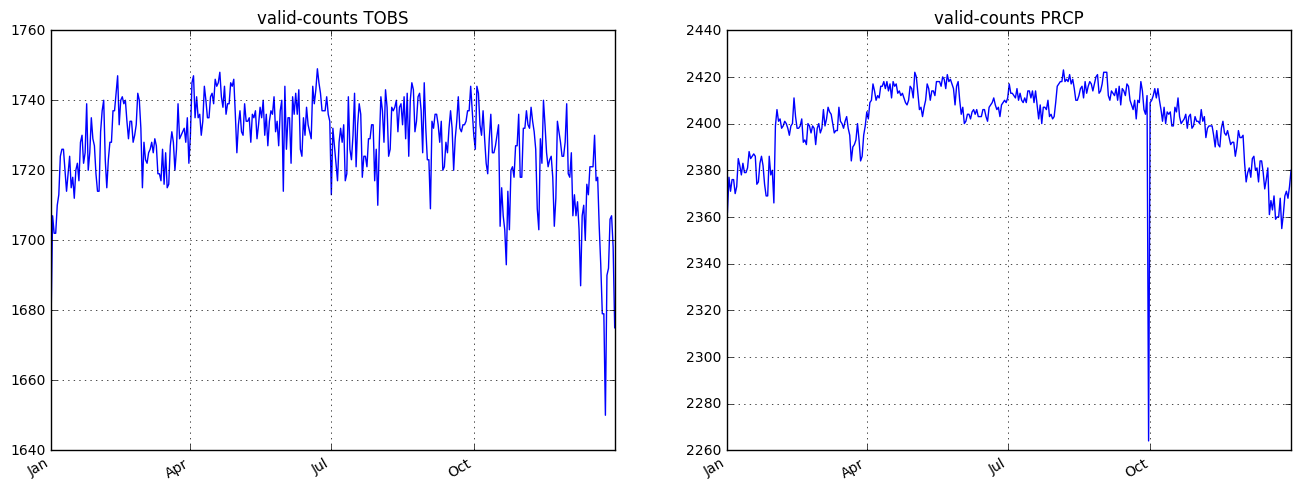

In [14]:
plot_pair(['TOBS','PRCP'],plot_valid)

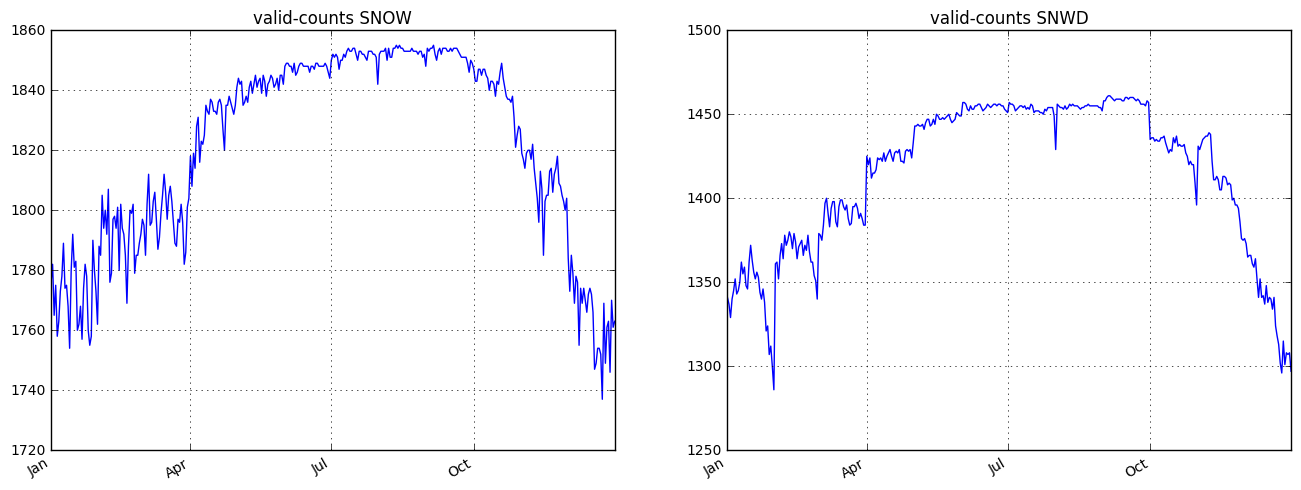

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [16]:
STAT['TMIN']['Var']
mean=STAT['TMIN']['Mean']
std=np.sqrt(STAT['TMIN']['Var'])
graphs=np.vstack([mean-std,mean,mean+std]).transpose()

In [17]:
graphs[0]

array([-149.03400489,  -92.10548885,  -35.17697281])

In [18]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10
    std=np.sqrt(STAT[m]['Var'])/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [19]:
STAT.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']

In [20]:
from datetime import date
start=365*1+1
dates=[date.fromordinal(i) for i in range(start,start+365)]
monthsFmt = DateFormatter("%b")
months = MonthLocator(range(1, 13), bymonthday=1, interval=3)

In [21]:
365 / 12

30

In [22]:
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [23]:
dict_cal = {}

In [24]:
key_list = []

In [25]:
STAT.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']

In [26]:
for key in STAT.keys():
    stats = []
    offset = 1
    print key
    if key in ['TMAX','TMIN','TOBS']:
        offset = 10
        
    for i, name in enumerate(month_names):
        i += 1
        stats.append(np.average(STAT[key]['Mean'][((i * 30) - 30):i * 30])/offset)
    
    key_list.append(np.array(np.float16(stats)))


TMIN
TOBS
TMAX
SNOW
SNWD
PRCP


In [27]:
np.float16(key_list[0])

array([ -8.21875   ,  -6.26953125,  -3.38085938,  -0.1003418 ,
         4.22265625,   8.5546875 ,  12.6875    ,  12.2265625 ,
         8.0546875 ,   2.53320312,  -3.0390625 ,  -7.3984375 ], dtype=float16)

In [28]:
month_names[np.argmax(np.float16(key_list[2]))]

'Jul'

In [29]:
print "Coolest month is {0}".format(month_names[np.argmin(np.float16(key_list[2]))])

Coolest month is Jan


In [30]:
print "Warmest month is {0}".format(month_names[np.argmax(np.float16(key_list[0]))])

Warmest month is Jul


In [31]:
key_list

[array([ -8.21875   ,  -6.26953125,  -3.38085938,  -0.1003418 ,
          4.22265625,   8.5546875 ,  12.6875    ,  12.2265625 ,
          8.0546875 ,   2.53320312,  -3.0390625 ,  -7.3984375 ], dtype=float16),
 array([ -0.87792969,   1.38867188,   5.171875  ,   9.328125  ,
         14.5234375 ,  19.953125  ,  23.03125   ,  21.734375  ,
         17.984375  ,  11.984375  ,   4.96875   ,  -0.15429688], dtype=float16),
 array([  5.16796875,   7.32421875,  11.453125  ,  15.9140625 ,
         21.296875  ,  26.984375  ,  30.53125   ,  29.28125   ,
         25.515625  ,  19.390625  ,  11.875     ,   6.14453125], dtype=float16),
 array([  6.48046875e+00,   5.91406250e+00,   4.53515625e+00,
          2.19921875e+00,   4.94140625e-01,   1.00524902e-01,
          3.43513489e-03,   2.28500366e-03,   4.04663086e-02,
          5.67382812e-01,   2.57421875e+00,   4.71484375e+00], dtype=float16),
 array([  8.60000000e+01,   8.69375000e+01,   5.58750000e+01,
          2.40000000e+01,   7.41796875e+00,   

In [32]:
np.array(key_list).shape

(6, 12)

In [33]:
for i, key in enumerate(STAT.keys()):
    print i, key
    print type(key_list[i])

0 TMIN
<type 'numpy.ndarray'>
1 TOBS
<type 'numpy.ndarray'>
2 TMAX
<type 'numpy.ndarray'>
3 SNOW
<type 'numpy.ndarray'>
4 SNWD
<type 'numpy.ndarray'>
5 PRCP
<type 'numpy.ndarray'>


In [34]:
STAT.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']

In [35]:
for key in STAT.keys():
    cstring= ""
    offset = 1
    if key in ['TMAX','TMIN','TOBS']:
        offset = 10

    for i, name in enumerate(month_names):
        i += 1
        cstring += "{0:.2f}".format(np.average(STAT[key]['Mean'][((i * 30) - 30):i * 30])/offset) + "\t"
    print cstring

-8.22	-6.27	-3.38	-0.10	4.22	8.55	12.69	12.23	8.05	2.53	-3.04	-7.40	
-0.88	1.39	5.17	9.33	14.53	19.96	23.03	21.74	17.98	11.99	4.97	-0.15	
5.17	7.33	11.46	15.91	21.29	26.99	30.53	29.28	25.51	19.39	11.88	6.14	
6.48	5.91	4.54	2.20	0.49	0.10	0.00	0.00	0.04	0.57	2.57	4.71	
85.99	86.97	55.89	24.00	7.42	0.25	0.00	0.00	0.02	0.97	12.36	38.98	
10.37	12.07	11.47	8.20	6.45	3.97	8.67	12.18	9.37	9.99	9.24	8.87	


In [36]:
master = []
labels = []
for key in [key for key in STAT.keys() if key not in ['TMAX','TMIN']] :
    labels.append(key)
    v= []
    offset = 1
    if key in ['TMAX','TMIN','TOBS']:
        offset = 10

    for i, name in enumerate(month_names):
        i += 1
        v.append (np.average(STAT[key]['Mean'][((i * 30) - 30):i * 30])/offset)
    master.append((v))


In [37]:
labels

['TOBS', 'SNOW', 'SNWD', 'PRCP']

In [38]:
len(master)

4

In [39]:
corr = np.corrcoef(master)

In [236]:
corr

array([[ 1.        , -0.93014062, -0.82286127, -0.34936025],
       [-0.93014062,  1.        ,  0.96074093,  0.44723864],
       [-0.82286127,  0.96074093,  1.        ,  0.47428173],
       [-0.34936025,  0.44723864,  0.47428173,  1.        ]])

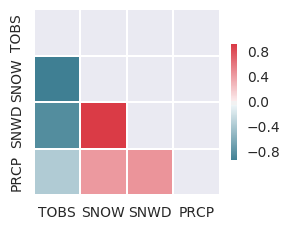

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(3, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=labels, yticklabels=labels,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [43]:
cstring= ""
for i, name in enumerate(month_names):
    i += 1
    cstring += "{0:.2f}".format(np.average(STAT['TMAX']['Mean'][((i * 30) - 30):i * 30])/10) + "\t"
print cstring

5.17	7.33	11.46	15.91	21.29	26.99	30.53	29.28	25.51	19.39	11.88	6.14	


In [44]:
cstring= ""
for i, name in enumerate(month_names):
    i += 1
    cstring += "{0:.2f}".format(np.average(STAT['TMIN']['Mean'][((i * 30) - 30):i * 30])/10) + "\t"
print cstring

-8.22	-6.27	-3.38	-0.10	4.22	8.55	12.69	12.23	8.05	2.53	-3.04	-7.40	


In [45]:
cstring= ""
for i, name in enumerate(month_names):
    i += 1
    cstring += "{0:.2f}".format(np.average(STAT['TOBS']['Mean'][((i * 30) - 30):i * 30])/10) + "\t"
print cstring

-0.88	1.39	5.17	9.33	14.53	19.96	23.03	21.74	17.98	11.99	4.97	-0.15	


In [46]:
cstring= ""
for i, name in enumerate(month_names):
    i += 1
    cstring += "{0:.2f}".format(np.average(STAT['TOBS']['Mean'][((i * 30) - 30):i * 30])/10) + "\t"
print cstring

-0.88	1.39	5.17	9.33	14.53	19.96	23.03	21.74	17.98	11.99	4.97	-0.15	


In [47]:
cstring= ""
for i, name in enumerate(month_names):
    i += 1
    cstring += "{0:.2f}".format(np.average(STAT['TOBS']['Mean'][((i * 30) - 30):i * 30])/10) + "\t"
print cstring

-0.88	1.39	5.17	9.33	14.53	19.96	23.03	21.74	17.98	11.99	4.97	-0.15	


In [48]:
for i, name in enumerate(month_names):
    i += 1
    print np.average(STAT['TOBS']['Mean'][((i * 30) - 30):i * 30])/10

-0.877793547286
1.38866922625
5.17207983195
9.33062449257
14.5251376122
19.9582533839
23.0342025535
21.7375360873
17.9778329582
11.9873388804
4.97015873786
-0.154324272137


In [49]:
for i, name in enumerate(month_names):
    i += 1
    print np.average(STAT['PRCP']['Mean'][((i * 30) - 30):i * 30])

10.374860282
12.0713142699
11.4681588437
8.19837697183
6.44959460463
3.97216400631
8.66903090153
12.1802793454
9.37350180816
9.9906792505
9.2384172898
8.87041125071


In [50]:
for i, name in enumerate(month_names):
    i += 1
    print np.average(STAT['SNWD']['Mean'][((i * 30) - 30):i * 30])

85.9923531525
86.9662312314
55.8854560213
24.0025422561
7.41848654219
0.24984144414
0.0
0.00114508200848
0.0150776059256
0.968653654513
12.355493958
38.9797497143


In [51]:
STAT['TMAX']['Mean']

array([  41.14578005,   39.83550694,   39.75358045,   39.55536913,
         41.03058232,   45.05786164,   45.68736974,   50.0663606 ,
         51.11106472,   53.55861494,   53.89979123,   50.41154329,
         53.18856904,   57.03963287,   56.46430063,   52.11422594,
         54.30451128,   56.9122807 ,   57.49707113,   53.3903454 ,
         50.33208333,   50.11634696,   54.44202595,   56.60191348,
         58.11348409,   57.87181628,   56.26894255,   57.20025031,
         58.69568823,   59.08284763,   58.45944816,   59.03322259,
         59.08697462,   63.53488372,   66.22936541,   67.09738914,
         66.29323308,   67.71006656,   65.7365569 ,   66.77372565,
         70.18659495,   69.27412008,   71.19132231,   72.72625929,
         71.21555647,   72.64601404,   75.77190083,   78.43530384,
         76.80621118,   75.35389073,   75.12021631,   78.03525508,
         80.42626346,   79.81618257,   83.47222222,   85.1179892 ,
         85.25901368,   84.31565866,   85.37095436,   87.12312

In [68]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/toby/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'mean', 'std', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


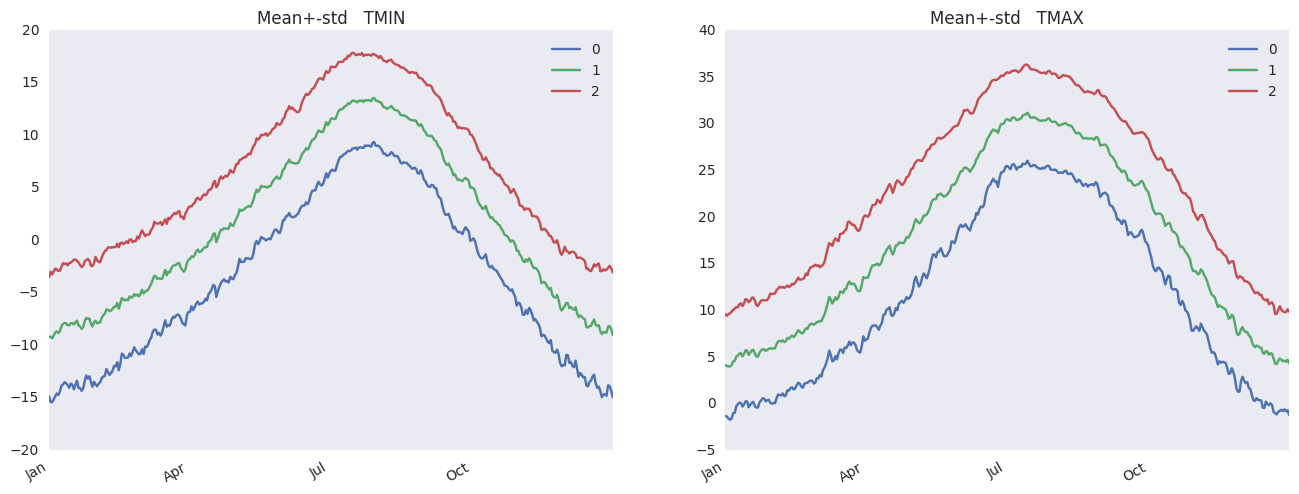

In [69]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

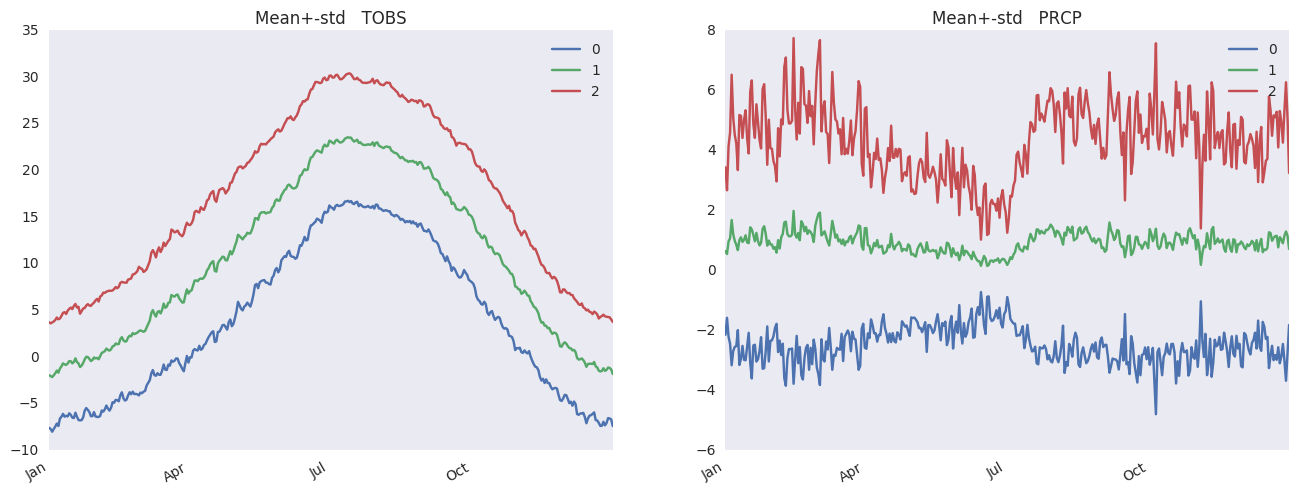

In [53]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

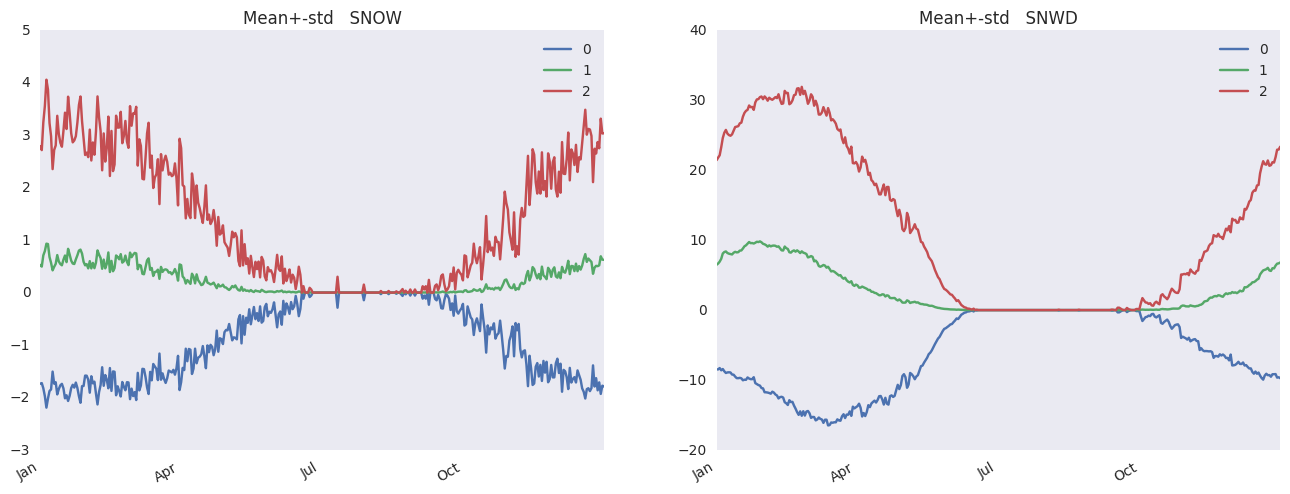

In [54]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [55]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

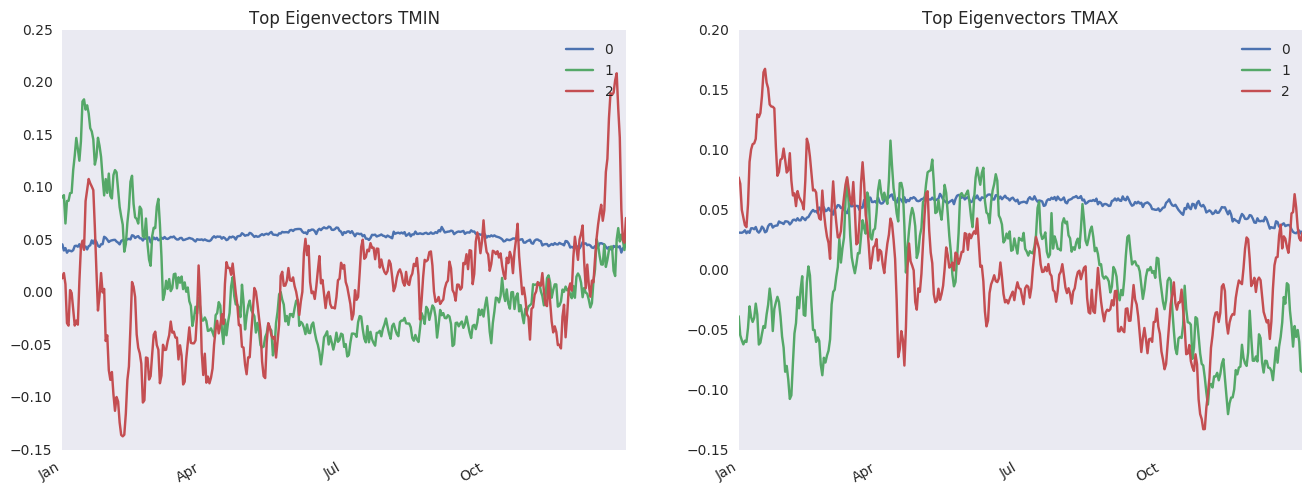

In [56]:
plot_pair(['TMIN','TMAX'],plot_eigen)

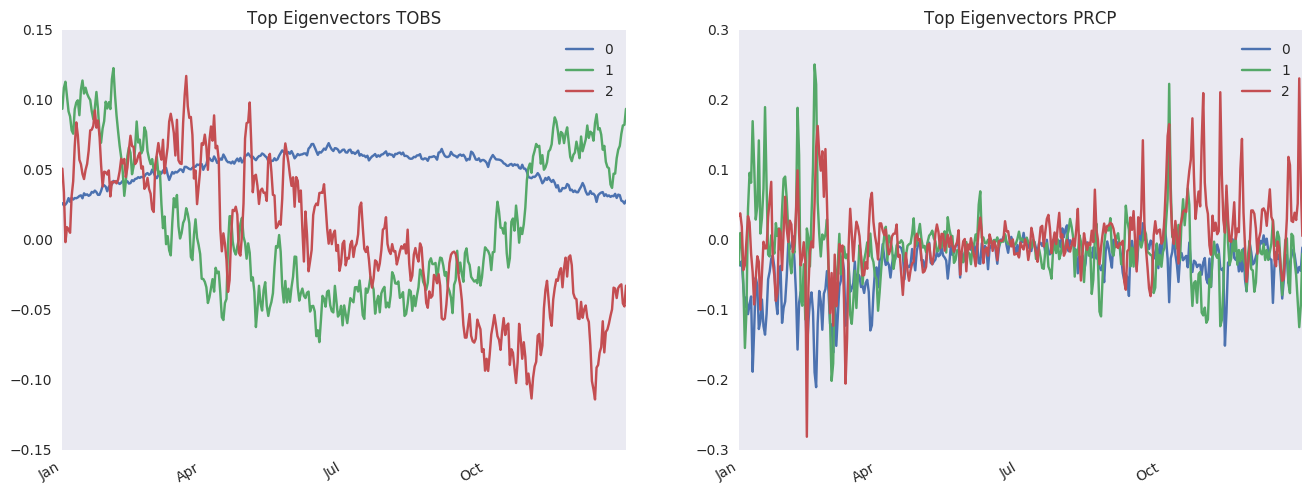

In [57]:
plot_pair(['TOBS','PRCP'],plot_eigen)

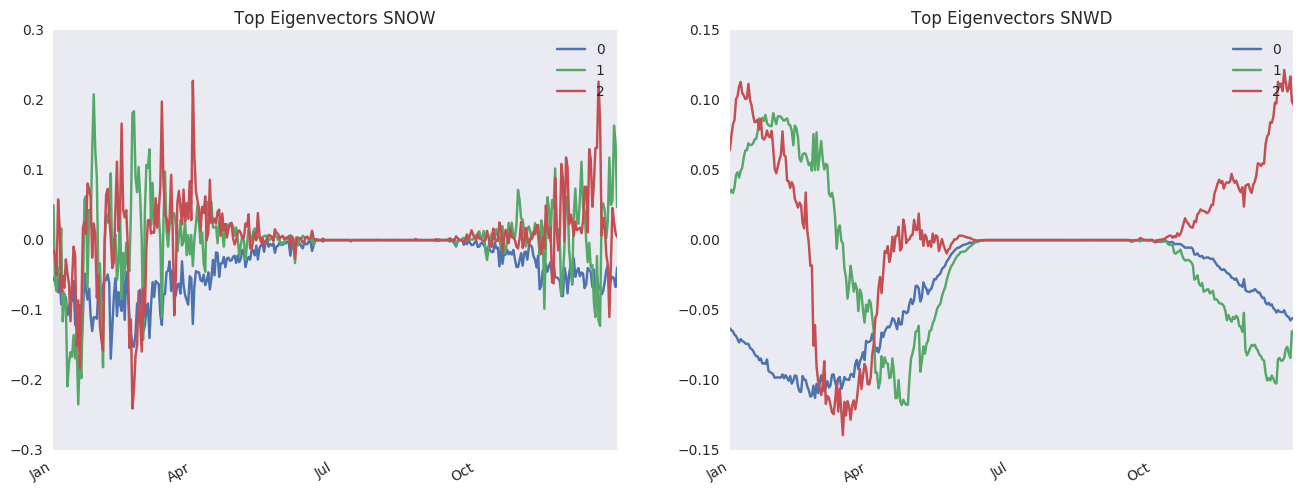

In [58]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [59]:
cumsum(STAT['TMIN']['eigval'][:5])/sum(STAT['TMIN']['eigval'])

array([ 0.38852597,  0.41811221,  0.4409985 ,  0.46180147,  0.47809982])

In [60]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=50
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

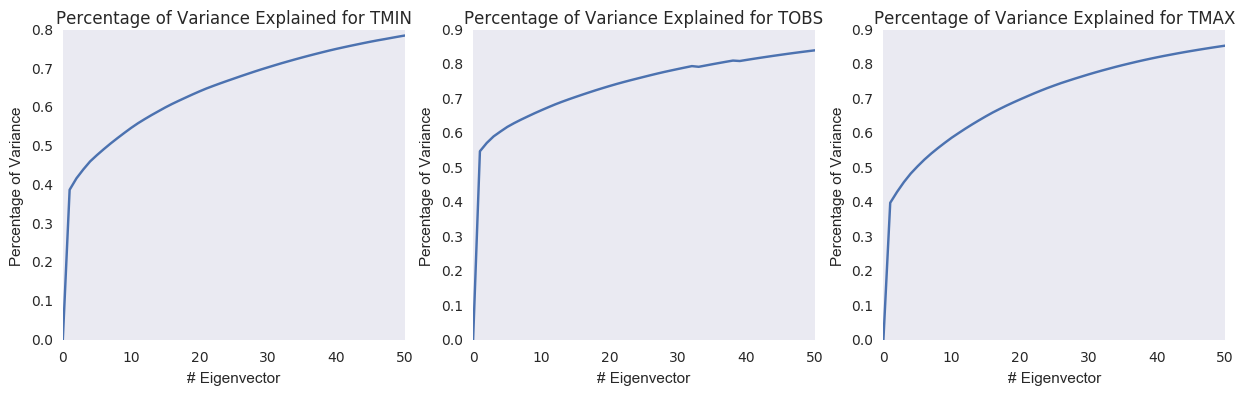

In [63]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

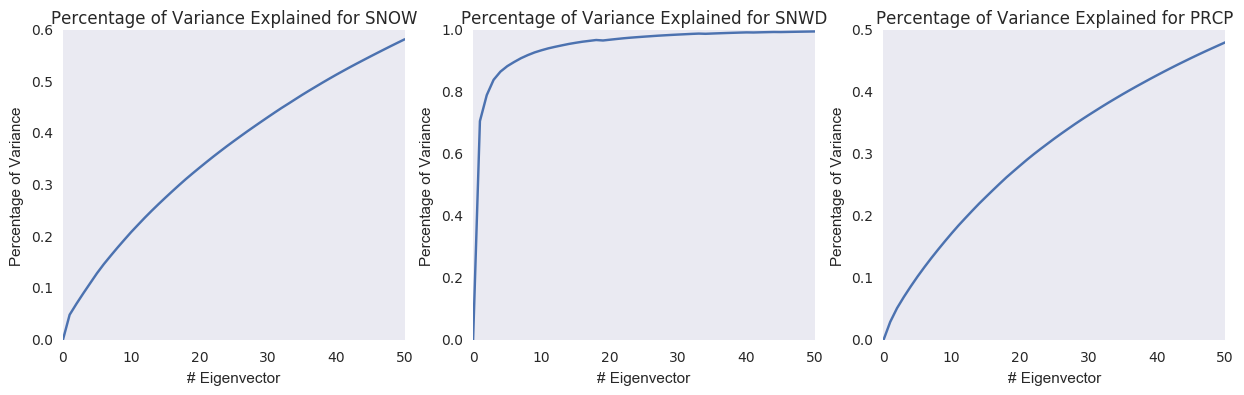

In [64]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [65]:
#sc.stop()

In [66]:
sqlContext

In [67]:
Query= """\
SELECT * FROM weather
"""
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()

SELECT * FROM weather

12433 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|     4|[80 4D 80 C9 00 0...|1907.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    29|[00 7E A0 53 00 C...|1911.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    18|[40 CC 40 4C 80 C...|1912.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    36|[40 56 A0 56 58 5...|1915.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    40|[20 50 30 54 30 5...|1916.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|    38|[20 50 00 46 80 4...|1917.0|SSSBBSSB|
|   1731.9| 37.6833|-113.0833|       TMAX|USC00421272|     3|[80 58 40 56 4